In [1]:
import pandas as pd
import numpy as np
import requests
import os
import spacy
import nltk
import warnings
from dotenv import load_dotenv
from tqdm import tqdm
from datetime import datetime, timedelta
from arch import arch_model
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
load_dotenv()
tqdm.pandas()

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
def process_text(text):
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc if not token.is_stop]
    return lemmatized

In [4]:
# Global Variables
api_key = os.getenv('FMP_API_KEY')
ticker = 'NVDA'
interval = '1hour'
start_date = datetime.strptime('2021-01-01', '%Y-%m-%d') # keep more left tail data to take care of NAs
end_date = datetime.strptime('2024-02-01', '%Y-%m-%d')

In [5]:
days_per_interval = 30

total_intervals = (end_date - start_date).days // days_per_interval

data_list = []


for i in tqdm(range(1, total_intervals + 1)):
    # Calculate the start and end dates for the current interval
    interval_start_date = start_date + timedelta(days=i*days_per_interval)
    interval_end_date = start_date + timedelta(days=(i+1)*days_per_interval)

    interval_start_date_str = interval_start_date.strftime('%Y-%m-%d')
    interval_end_date_str = interval_end_date.strftime('%Y-%m-%d')

    url = f'https://financialmodelingprep.com/api/v3/historical-chart/{interval}/{ticker}?from={interval_start_date_str}&to={interval_end_date_str}&apikey={api_key}'
    response = requests.get(url).json()


    data_list.append(pd.DataFrame(response))


data = pd.concat(data_list)


data.head()

100%|██████████| 37/37 [00:44<00:00,  1.20s/it]


,date,open,low,high,close,volume
0,2021-03-02 15:30:00,134.1468,133.9375,135.8000,135.4313,4865972
1,2021-03-02 14:30:00,135.2709,135.2075,136.2000,135.6374,2657136
2,2021-03-02 13:30:00,135.9250,135.5900,136.9043,136.5700,2129432
3,2021-03-02 12:30:00,136.7075,135.9250,136.8025,136.0125,2142952
4,2021-03-02 11:30:00,136.0500,135.7525,136.7450,136.3650,2944656


In [6]:
data.sort_values(by='date', inplace=True)

In [7]:
# additional variables
data["log_return"] = np.log(data["close"] / data["close"].shift(1))
data["log_volume_change"] = np.log(data["volume"] / data["volume"].shift(1))
data["log_trading_range"] = np.log(data["high"] / data["low"])

In [8]:
data["previous_volatility_7"] = data["log_return"].rolling(window=7).std()
data["previous_volatility_3"] = data["log_return"].rolling(window=3).std()
data["future_volatility_7"] = data["log_return"].shift(-7).rolling(window=7).std()

In [9]:
data.dropna(inplace=True)

In [10]:
# data = data.loc[data["date"]>="2022-01-01"].reset_index(drop=True)
data["date"] = pd.to_datetime(data["date"])

In [11]:
data.head()

,date,open,low,high,close,volume,log_return,log_volume_change,log_trading_range,previous_volatility_7,previous_volatility_3,future_volatility_7
139,2021-02-02 09:30:00,133.3025,133.1125,135.1143,134.6750,5534824,0.018870,0.543639,0.014926,0.006998,0.010666,0.006781
138,2021-02-02 10:30:00,133.6250,132.8550,133.9825,133.0375,2662972,-0.012233,-0.731617,0.008451,0.009167,0.015571,0.002986
137,2021-02-02 11:30:00,134.3350,133.5400,134.5675,133.5625,2017932,0.003938,-0.277370,0.007665,0.009159,0.015556,0.004752
136,2021-02-02 12:30:00,133.8325,133.6950,134.6338,134.3100,1591220,0.005581,-0.237572,0.006997,0.009197,0.009845,0.005030
135,2021-02-02 13:30:00,134.5025,134.0050,134.7975,134.2231,1726548,-0.000647,0.081623,0.005897,0.009291,0.003228,0.005220


In [12]:
data_list = []

for page in tqdm(range(100)):
    url = f'https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}&page={page}&apikey={api_key}'

    response = requests.get(url).json()

    for item in response:
        data_list.append({'text': item['text'], 'publishedDate': item['publishedDate']})

news_data = pd.DataFrame(data_list)

news_data.head()

100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


,text,publishedDate
0,Nvidia's stock price has rocketed higher in a ...,2024-04-06 17:50:00
1,Nvidia (NASDAQ: NVDA ) recorded more than 220%...,2024-04-06 17:00:00
2,Japanese investment bank Mizuho believes Nvidi...,2024-04-06 16:19:00
3,"Nvidia, which was roughly trading at $63 per s...",2024-04-06 14:07:36
4,Nvidia stock has roared higher thanks to the c...,2024-04-06 11:30:00


In [13]:

# news_data['publishedDate'] = pd.to_datetime(news_data['publishedDate'])

# Define a function to calculate the half-hour interval for a given datetime
def get_half_hour_interval(dt):
    date = dt.date()
    hour = dt.hour
    minute = dt.minute
    if minute < 30:
        return pd.to_datetime(f'{date} {hour}:30', errors='coerce')
    else:
        return pd.to_datetime(f'{date} {hour+1}:30', errors='coerce')

news_data['half_hour_interval'] = pd.to_datetime(news_data['publishedDate']).apply(get_half_hour_interval)

news_data.head()

,text,publishedDate,half_hour_interval
0,Nvidia's stock price has rocketed higher in a ...,2024-04-06 17:50:00,2024-04-06 18:30:00
1,Nvidia (NASDAQ: NVDA ) recorded more than 220%...,2024-04-06 17:00:00,2024-04-06 17:30:00
2,Japanese investment bank Mizuho believes Nvidi...,2024-04-06 16:19:00,2024-04-06 16:30:00
3,"Nvidia, which was roughly trading at $63 per s...",2024-04-06 14:07:36,2024-04-06 14:30:00
4,Nvidia stock has roared higher thanks to the c...,2024-04-06 11:30:00,2024-04-06 12:30:00


In [14]:
news_data["tokenized_text"] = news_data["text"].progress_apply(process_text)

100%|██████████| 19160/19160 [01:57<00:00, 163.03it/s]


In [15]:
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

In [16]:
news_data["news_sentiment_score"] = news_data['tokenized_text'].apply(lambda x: get_sentiment_score(' '.join(x)))

In [17]:
data_w_news = (
    news_data.groupby('half_hour_interval')['news_sentiment_score'].mean().reset_index()
    .assign(half_hour_interval=lambda x: pd.to_datetime(x['half_hour_interval']))
    .merge(data, left_on='half_hour_interval', right_on='date', how='right')
    .drop(columns='half_hour_interval',axis=1)
    .assign(rolling_news_sentiment_7=lambda x: x['news_sentiment_score'].rolling(window=7,min_periods=1).mean())
)

In [18]:
press_list = []


for page in tqdm(range(100)):

    url = f'https://financialmodelingprep.com/api/v3/press-releases/{ticker}?page={page}&apikey={api_key}'


    response = requests.get(url).json()


    for item in response:
        press_list.append({'text': item['title'], 'publishedDate': item['date']})


press_data = pd.DataFrame(press_list)

press_data.head()


100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


,text,publishedDate
0,ALSET CAPITAL INC. ANNOUNCES SECURED LOAN TO A...,2024-04-02 03:05:00
1,BIATECH JOINS NVIDIA INCEPTION,2024-03-29 11:38:00
2,LIGHTNING AI ANNOUNCES AVAILABILITY OF THUNDER...,2024-03-28 10:00:00
3,"""MEDICAL IP, UNVEILING OF DIGITAL TWIN SIMULAT...",2024-03-27 19:00:00
4,PUREWEB UNVEILS SUPPORT FOR NVIDIA CLOUDXR ON ...,2024-03-20 13:00:00


In [19]:
press_data["tokenized_text"] = press_data["text"].progress_apply(process_text)

100%|██████████| 8294/8294 [00:30<00:00, 276.08it/s]


In [20]:
press_data["press_sentiment_score"] = press_data['tokenized_text'].apply(lambda x: get_sentiment_score(' '.join(x)))

In [21]:
press_data['half_hour_interval'] = pd.to_datetime(press_data['publishedDate']).apply(get_half_hour_interval)

In [22]:
data_w_news.drop(columns='rolling_news_sentiment_7',axis=1,inplace=True)

In [23]:
data_final = (
    press_data.groupby('half_hour_interval')['press_sentiment_score'].mean().reset_index()
    .merge(data_w_news, left_on='half_hour_interval', right_on='date', how='right')
    .drop(columns='half_hour_interval',axis=1)
    .assign(weight_avg_sentiment=lambda x: np.where(x['news_sentiment_score'].isna(), x['press_sentiment_score'], 
                                                    np.where(x['press_sentiment_score'].isna(), x['news_sentiment_score'], 
                                                             x['news_sentiment_score']*0.6 + x['press_sentiment_score']*0.4)))
    .assign(rolling_sentiment_7=lambda x: x['weight_avg_sentiment'].rolling(window=7,min_periods=1).mean())
)


In [24]:
def calculate_garch_volatility(data):
    # Fit GARCH model
    model = arch_model(data, vol='GARCH', p=7, q=7)
    model_fit = model.fit(disp='off')
    
    # Forecast volatility for a horizon of 7 intervals
    forecast = model_fit.forecast(horizon=7)
    return forecast.variance.values[-1][0]

# Calculate GARCH volatility using rolling window and apply the function
data_final["garch_volatility"] = data_final["log_return"].rolling(window=7).apply(calculate_garch_volatility)

/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/stock-volatility-prediction-5RuW2YLE-py3.12/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.596e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/stock-volatility-prediction-5RuW2YLE-py3.12/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.941e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either res

In [28]:
data_final

,press_sentiment_score,news_sentiment_score,date,open,low,high,close,volume,log_return,log_volume_change,log_trading_range,previous_volatility_7,previous_volatility_3,future_volatility_7,weight_avg_sentiment,rolling_sentiment_7,garch_volatility
0,NaN,0.493900,2021-02-02 09:30:00,133.3025,133.1125,135.1143,134.6750,5534824,0.018870,0.543639,0.014926,0.006998,0.010666,0.006781,0.493900,0.493900,NaN
1,NaN,NaN,2021-02-02 10:30:00,133.6250,132.8550,133.9825,133.0375,2662972,-0.012233,-0.731617,0.008451,0.009167,0.015571,0.002986,NaN,0.493900,NaN
2,NaN,NaN,2021-02-02 11:30:00,134.3350,133.5400,134.5675,133.5625,2017932,0.003938,-0.277370,0.007665,0.009159,0.015556,0.004752,NaN,0.493900,NaN
3,NaN,NaN,2021-02-02 12:30:00,133.8325,133.6950,134.6338,134.3100,1591220,0.005581,-0.237572,0.006997,0.009197,0.009845,0.005030,NaN,0.493900,NaN
4,NaN,0.440400,2021-02-02 13:30:00,134.5025,134.0050,134.7975,134.2231,1726548,-0.000647,0.081623,0.005897,0.009291,0.003228,0.005220,0.440400,0.467150,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,NaN,0.074433,2024-02-14 11:30:00,727.0000,721.8700,729.1000,726.5000,5366623,-0.017005,-0.599035,0.009966,0.014699,0.022074,0.003390,0.074433,0.441258,0.000035
5504,NaN,NaN,2024-02-14 12:30:00,727.8700,724.5000,735.0002,729.2050,4553647,0.003716,-0.164270,0.014389,0.014768,0.012784,0.003272,NaN,0.387301,0.000135
5505,NaN,0.757433,2024-02-14 13:30:00,729.6460,726.4001,731.7999,729.5450,4102110,0.000466,-0.104427,0.007406,0.014465,0.011145,0.003403,0.757433,0.488874,0.000154
5506,NaN,0.466850,2024-02-14 14:30:00,732.8400,730.0200,734.7200,730.8700,4407749,0.001815,0.071863,0.006418,0.014457,0.001633,0.003386,0.466850,0.501686,20.559436


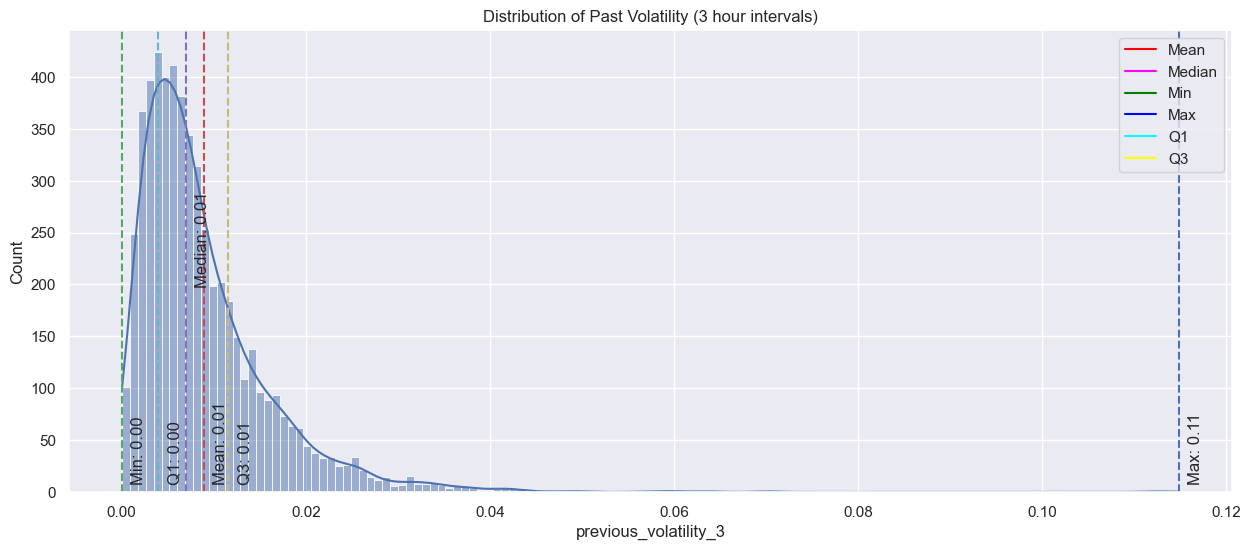

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Set the theme to ggplot
sns.set_theme(style="darkgrid")

mean = data_final["previous_volatility_3"].mean()
median = data_final["previous_volatility_3"].median()
min_val = data_final["previous_volatility_3"].min()
max_val = data_final["previous_volatility_3"].max()
q1 = np.percentile(data_final["previous_volatility_3"], 25)
q3 = np.percentile(data_final["previous_volatility_3"], 75)

# Create the histogram
plt.figure(figsize=(15, 6))
sns.histplot(data_final["previous_volatility_3"], kde=True)

# Add labels for summary statistics
plt.axvline(mean, color='r', linestyle='--')
plt.text(mean+0.001, 10, f'Mean: {mean:.2f}', rotation=90)
plt.axvline(median, color='m', linestyle='--')
plt.text(median+0.001, 200, f'Median: {median:.2f}', rotation=90)
plt.axvline(min_val, color='g', linestyle='--')
plt.text(min_val+0.001, 10, f'Min: {min_val:.2f}', rotation=90)
plt.axvline(max_val, color='b', linestyle='--')
plt.text(max_val+0.001, 10, f'Max: {max_val:.2f}', rotation=90)
plt.axvline(q1, color='c', linestyle='--')
plt.text(q1+0.001, 10, f'Q1: {q1:.2f}', rotation=90)
plt.axvline(q3, color='y', linestyle='--')
plt.text(q3+0.001, 10, f'Q3: {q3:.2f}', rotation=90)


# Add a title
plt.title('Distribution of Past Volatility (3 hour intervals)')

red_line = mlines.Line2D([], [], color='red', markersize=15, label='Mean')
magenta_line = mlines.Line2D([], [], color='magenta', markersize=15, label='Median')
green_line = mlines.Line2D([], [], color='green', markersize=15, label='Min')
blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='Max')
cyan_line = mlines.Line2D([], [], color='cyan', markersize=15, label='Q1')
yellow_line = mlines.Line2D([], [], color='yellow', markersize=15, label='Q3')
plt.legend(handles=[red_line, magenta_line, green_line, blue_line, cyan_line, yellow_line],loc='upper right')

# Show the plot
plt.show()

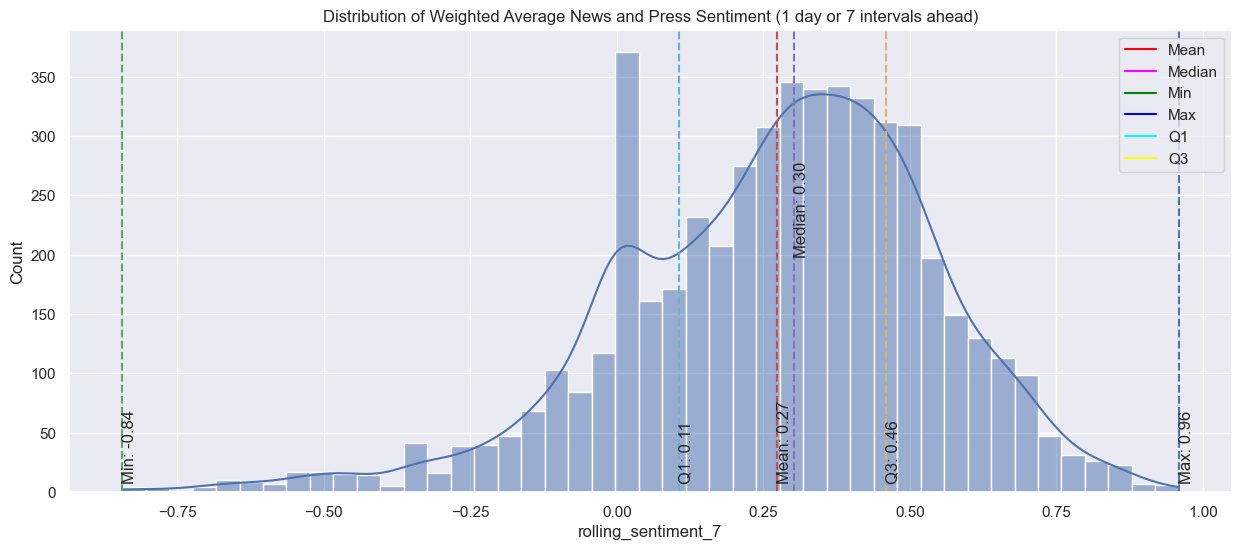

In [74]:
mean = data_final["rolling_sentiment_7"].mean()
median = data_final["rolling_sentiment_7"].median()
min_val = data_final["rolling_sentiment_7"].min()
max_val = data_final["rolling_sentiment_7"].max()
q1 = np.nanpercentile(data_final["rolling_sentiment_7"], 25)
q3 = np.nanpercentile(data_final["rolling_sentiment_7"], 75)

# Create the histogram
plt.figure(figsize=(15, 6))
sns.histplot(data_final["rolling_sentiment_7"], kde=True)

# Add labels for summary statistics
plt.axvline(mean, color='r', linestyle='--')
plt.text(mean, 10, f'Mean: {mean:.2f}', rotation=90)
plt.axvline(median, color='m', linestyle='--')
plt.text(median, 200, f'Median: {median:.2f}', rotation=90)
plt.axvline(min_val, color='g', linestyle='--')
plt.text(min_val, 10, f'Min: {min_val:.2f}', rotation=90)
plt.axvline(max_val, color='b', linestyle='--')
plt.text(max_val, 10, f'Max: {max_val:.2f}', rotation=90)
plt.axvline(q1, color='c', linestyle='--')
plt.text(q1, 10, f'Q1: {q1:.2f}', rotation=90)
plt.axvline(q3, color='y', linestyle='--')
plt.text(q3, 10, f'Q3: {q3:.2f}', rotation=90)


# Add a title
plt.title('Distribution of Weighted Average News and Press Sentiment (1 day or 7 intervals ahead)')

red_line = mlines.Line2D([], [], color='red', markersize=15, label='Mean')
magenta_line = mlines.Line2D([], [], color='magenta', markersize=15, label='Median')
green_line = mlines.Line2D([], [], color='green', markersize=15, label='Min')
blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='Max')
cyan_line = mlines.Line2D([], [], color='cyan', markersize=15, label='Q1')
yellow_line = mlines.Line2D([], [], color='yellow', markersize=15, label='Q3')
plt.legend(handles=[red_line, magenta_line, green_line, blue_line, cyan_line, yellow_line])

# Show the plot
plt.show()